# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [2]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection as cross_validation
import warnings
warnings.filterwarnings("ignore")

In [3]:
# using SQLite Table to read data.
con = sqlite3.connect('amazon-fine-food-reviews/database.sqlite') 

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 50000""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (50000, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [4]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [5]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [6]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [7]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [8]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [10]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(46072, 10)

In [11]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

92.144

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [12]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [13]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [14]:
#Before starting the next phase of preprocessing lets see the number of entries left
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(46071, 10)


1    38479
0     7592
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [15]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [16]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [17]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.
this is yummy, easy and unusual. it makes a quick, delicous pie, crisp or cobbler. home made is better, but a heck of a lot more work. this is great to have on hand for last minute dessert needs where you really want to impress wih your creativity in cooking! recommended.
Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...
For those of you wanting a high-quality, yet affordable green tea, you should definitely give this one a try. Let me first star

In [18]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [19]:
sent_1500 = decontracted(sent_1500)
print(sent_1500)
print("="*50)

Great flavor, low in calories, high in nutrients, high in protein! Usually protein powders are high priced and high in calories, this one is a great bargain and tastes great, I highly recommend for the lady gym rats, probably not "macho" enough for guys since it is soy based...


In [20]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My dogs loves this chicken but its a product from China, so we wont be buying it anymore.  Its very hard to find any chicken products made in the USA but they are out there, but this one isnt.  Its too bad too because its a good product but I wont take any chances till they know what is going on with the china imports.


In [21]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

Great flavor low in calories high in nutrients high in protein Usually protein powders are high priced and high in calories this one is a great bargain and tastes great I highly recommend for the lady gym rats probably not macho enough for guys since it is soy based 


In [22]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [23]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())

100%|██████████| 46071/46071 [00:18<00:00, 2438.81it/s]


In [24]:
preprocessed_reviews[1500]

'great flavor low calories high nutrients high protein usually protein powders high priced high calories one great bargain tastes great highly recommend lady gym rats probably not macho enough guys since soy based'

<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [25]:
## Similartly you can do preprocessing for review summary also.
len(preprocessed_reviews)

46071

# [4] Featurization

## [4.1] BAG OF WORDS

In [26]:

labels = final.head(100000)['Score']
# split the train data set into cross validation train and cross validation test

X_1_bow, X_test_bow, y_1_bow, y_test_bow = cross_validation.train_test_split(preprocessed_reviews[:100000],labels, test_size=0.3, random_state=0)
X_tr_bow, X_cv_bow, y_tr_bow, y_cv_bow = cross_validation.train_test_split(X_1_bow, y_1_bow, test_size=0.3)
count_vect = CountVectorizer(min_df=10) #in scikit-learn

X_tr_bow = count_vect.fit_transform(X_tr_bow)
X_cv_bow = count_vect.transform(X_cv_bow)
X_test_bow =count_vect.transform(X_test_bow)
X_1_bow = count_vect.transform(X_1_bow)
print("some feature names ", count_vect.get_feature_names()[:10])


some feature names  ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'acai', 'accept', 'acceptable']


In [27]:
labels.value_counts()

1    38479
0     7592
Name: Score, dtype: int64

<h3>Balancing the Dataset<h3>

In [28]:
from imblearn.under_sampling import RandomUnderSampler

from collections import Counter

sm = RandomUnderSampler(random_state=42)
X_res, y_res = sm.fit_resample(X_tr_bow,y_tr_bow)
print('Resampled dataset shape %s' % Counter(y_res))


Resampled dataset shape Counter({0: 3778, 1: 3778})


## [4.2] Bi-Grams and n-Grams.

In [29]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (46071, 27311)
the number of unique words including both unigrams and bigrams  27311


## [4.3] TF-IDF

In [30]:
# split the train data set into cross validation train and cross validation test

X_1_tfidv, X_test_tfidv, y_1_tfidv, y_test_tfidv = cross_validation.train_test_split(preprocessed_reviews[:100000],labels, test_size=0.3, random_state=0)
X_tr_tfidv, X_cv_tfidv, y_tr_tfidv, y_cv_tfidv = cross_validation.train_test_split(X_1_tfidv, y_1_tfidv, test_size=0.3)
tf_idf_vect = TfidfVectorizer( min_df=10)

X_tr_tfidv = tf_idf_vect.fit_transform(X_tr_tfidv)
X_cv_tfidv = tf_idf_vect.transform(X_cv_tfidv)
X_test_tfidv =tf_idf_vect.transform(X_test_tfidv)
X_1_tfidv = tf_idf_vect.transform(X_1_tfidv)


print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])


some sample features(unique words in the corpus) ['ability', 'able', 'absolute', 'absolutely', 'absorb', 'absorbed', 'absorbs', 'acai', 'accept', 'acceptable']


## [4.4] Word2Vec

In [31]:
# Train your own Word2Vec model using your own text corpus
X_1_w2v, X_test_w2v, y_1_w2v, y_test_w2v = cross_validation.train_test_split(preprocessed_reviews[:100000],labels, test_size=0.3, random_state=0)
X_tr_w2v, X_cv_w2v, y_tr_w2v, y_cv_w2v = cross_validation.train_test_split(X_1_w2v, y_1_w2v, test_size=0.3)

i=0
list_of_sentance=[]
for sentance in X_tr_w2v:
    list_of_sentance.append(sentance.split())

In [32]:
# Using Google News Word2Vectors

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 8 times
    w2v_model=Word2Vec(list_of_sentance,min_count=8,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('awesome', 0.8397209048271179), ('amazing', 0.8284739255905151), ('fantastic', 0.8114446401596069), ('good', 0.8020437359809875), ('excellent', 0.7840793132781982), ('perfect', 0.7315860390663147), ('wonderful', 0.7274272441864014), ('terrific', 0.7269355654716492), ('delicious', 0.6603590846061707), ('decent', 0.6414519548416138)]
[('closest', 0.8002853989601135), ('nastiest', 0.7980291247367859), ('repulsive', 0.7539653182029724), ('terrible', 0.7309121489524841), ('greatest', 0.7304129600524902), ('tasted', 0.7301374077796936), ('eaten', 0.72745281457901), ('addicted', 0.719547688961029), ('hottest', 0.7149007320404053), ('ever', 0.7147586941719055)]


In [33]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 8 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 8 times  6982
sample words  ['lb', 'mini', 'schnauzer', 'easily', 'started', 'bone', 'matter', 'minutes', 'ever', 'hungry', 'dog', 'swallowed', 'pieces', 'seeing', 'took', 'away', 'ate', 'third', 'less', 'hrs', 'later', 'time', 'breakfast', 'standard', 'refused', 'eat', 'first', 'break', 'overnight', 'fast', 'hunger', 'must', 'gotten', 'better', 'gave', 'almost', 'usually', 'cleans', 'little', 'bowl', 'hour', 'threw', 'four', 'rounds', 'could', 'see', 'small', 'softened', 'yet', 'still']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [34]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors_tr = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_tr.append(sent_vec)
print(len(sent_vectors_tr))
print(len(sent_vectors_tr[0]))

100%|██████████| 22574/22574 [00:31<00:00, 713.30it/s]

22574
50


In [35]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_test_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_test = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_test.append(sent_vec)
print(len(sent_vectors_test))
print(len(sent_vectors_test[0]))

100%|██████████| 13822/13822 [00:19<00:00, 704.24it/s]

13822
50


In [36]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_cv_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_cv = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_cv.append(sent_vec)
print(len(sent_vectors_cv))
print(len(sent_vectors_cv[0]))

100%|██████████| 9675/9675 [00:13<00:00, 708.58it/s]

9675
50


In [37]:
# compute average word2vec for each review.
list_of_sentance=[]
for sentance in X_1_w2v:
    list_of_sentance.append(sentance.split())
sent_vectors_1 = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors_1.append(sent_vec)
print(len(sent_vectors_1))
print(len(sent_vectors_1[0]))

100%|██████████| 32249/32249 [00:45<00:00, 706.66it/s]

32249
50


#### [4.4.1.2] TFIDF weighted W2v

In [38]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()

tf_idf_matrix = model.fit_transform(X_tr_w2v)

# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))
tfidf_feat = model.get_feature_names()

In [39]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_1 = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_1_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_1.append(sent_vec)
    row += 1

100%|██████████| 32249/32249 [07:31<00:00, 71.45it/s]


In [40]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_test = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_test_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_test.append(sent_vec)
    row += 1

100%|██████████| 13822/13822 [03:08<00:00, 73.15it/s]


In [41]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_cv = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_cv_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_cv.append(sent_vec)
    row += 1

100%|██████████| 9675/9675 [02:16<00:00, 70.93it/s]


In [42]:
# TF-IDF weighted Word2Vec
 # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors_tr = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
list_of_sentance=[]
for sentance in X_tr_w2v:
    list_of_sentance.append(sentance.split())
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors_tr.append(sent_vec)
    row += 1

100%|██████████| 22574/22574 [05:10<00:00, 72.59it/s]


# [5] Assignment 5: Apply Logistic Regression

<ol>
    <li><strong>Apply Logistic Regression on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
            <li><font color='red'>SET 3:</font>Review text, preprocessed one converted into vectors using (AVG W2v)</li>
            <li><font color='red'>SET 4:</font>Review text, preprocessed one converted into vectors using (TFIDF W2v)</li>
        </ul>
    </li>
    <br>
    <li><strong>Hyper paramter tuning (find best hyper parameters corresponding the algorithm that you choose)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>          
        </ul>
    </li>
    <br>
    <li><strong>Pertubation Test</strong>
        <ul>
    <li>Get the weights W after fit your model with the data X i.e Train data.</li>
    <li>Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse
matrix, X.data+=e)</li>
    <li>Fit the model again on data X' and get the weights W'</li>
    <li>Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e
W=W+10^-6 and W’ = W’+10^-6</li>
    <li>Now find the % change between W and W' (| (W-W') / (W) |)*100)</li>
    <li>Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector</li>
    <li> Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to 34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is sudden rise the values, assume it is 2.5</li>
            <li> Print the feature names whose % change is more than a threshold x(in our example it's 2.5)</li>
        </ul>
    </li>
    <br>
    <li><strong>Sparsity</strong>
        <ul>
    <li>Calculate sparsity on weight vector obtained after using L1 regularization</li>
        </ul>
    </li>
    <br><font color='red'>NOTE: Do sparsity and multicollinearity for any one of the vectorizers. Bow or tf-idf is recommended.</font>
    <br>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Get top 10 important features for both positive and negative classes separately.</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

# Applying Logistic Regression

## [5.1] Logistic Regression on BOW,<font color='red'> SET 1</font>

### [5.1.1] Applying Logistic Regression with L1 regularization on BOW,<font color='red'> SET 1</font>

In [43]:
from sklearn.linear_model import LogisticRegression

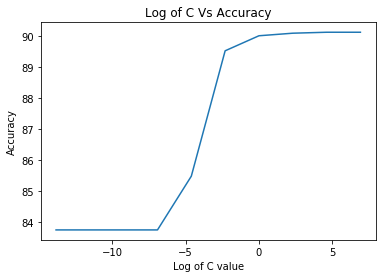

Best value of C is : 100.000000


In [44]:


from sklearn.metrics import accuracy_score
ch = .0000001
x = []
y = []
for i in range(1,11):
    # instantiate learning model (C  = 0.000001)
    clf = LogisticRegression(penalty = 'l1',random_state=0, solver='saga', C = ch *10,multi_class="auto",tol=.01)
    ch = ch * 10
    # fitting the model on crossvalidation train
    clf.fit(X_tr_bow, y_tr_bow)
    # predict the response on the crossvalidation train
    pred = clf.predict(X_cv_bow)
    # evaluate CV accuracy
    acc = accuracy_score(y_cv_bow, pred, normalize=True) * int(100)
  
    x.append(np.log(ch))
    y.append(acc)

plt.xlabel('Log of C value')
plt.ylabel('Accuracy')

plt.title("Log of C Vs Accuracy")
best = y.index(max(y))

plt.plot(x,y)
plt.show()

print("Best value of C is : %f"% (np.exp(x[best])))

In [46]:
clf = LogisticRegression(penalty = 'l1',random_state=0, solver='saga', C = 100 ,multi_class="auto",tol=.01)

clf.fit(X_1_bow, y_1_bow)
   
pred = clf.predict(X_test_bow)
   
acc = accuracy_score(y_test_bow, pred, normalize=True) * int(100)

acc

90.81898422804225

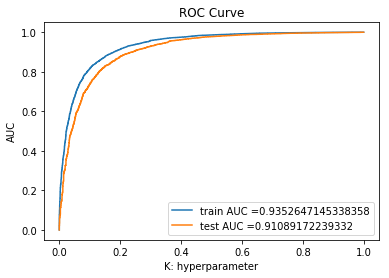

In [47]:
#ROC curve for test and train data
from sklearn.metrics import roc_curve, auc

clf = LogisticRegression(penalty = 'l1',random_state=0, solver='saga', C = 100 ,multi_class="auto",tol=.01)
clf.fit(X_tr_bow, y_tr_bow)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_bow, clf.predict_proba(X_tr_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_bow, clf.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)



In [48]:
#took help from "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
confusion_matrix(y_test_bow, clf.predict(X_test_bow), labels=[0, 1])

array([[ 1261,   980],
       [  353, 11228]])

#### [5.1.1.1] Calculating sparsity on weight vector obtained using L1 regularization on BOW,<font color='red'> SET 1</font>

In [57]:
# Please write all the code with proper documentation
clf = LogisticRegression(C=1, penalty='l1');
clf.fit(X_tr_bow, y_tr_bow);
w = clf.coef_
print(np.count_nonzero(w))
print(len(w[0]))

2257
5733


### [5.1.2] Applying Logistic Regression with L2 regularization on BOW,<font color='red'> SET 1</font>

In [58]:
from sklearn.linear_model import LogisticRegression

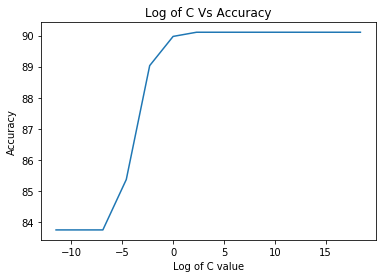

Best value of C is : 10.000000


In [59]:
from sklearn.linear_model import LogisticRegression
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]
from sklearn.metrics import accuracy_score
ch = .0000001
x = []
y = []
for i in range(1,15):
    # instantiate learning model (k = 30)
    clf = LogisticRegression(penalty = 'l2',random_state=0, solver='saga', C = ch *10,multi_class="auto",tol = .01)
    ch = ch * 10
    # fitting the model on crossvalidation train
    clf.fit(X_tr_bow, y_tr_bow)
    # predict the response on the crossvalidation train
    pred = clf.predict(X_cv_bow)
    # evaluate CV accuracy
    acc = accuracy_score(y_cv_bow, pred, normalize=True) * int(100)
    #print('\nCV accuracy for alpha = %d is %d%%' % (al*10, acc))
    x.append(np.log(ch*10))
    y.append(acc)

plt.xlabel('Log of C value')
plt.ylabel('Accuracy')

plt.title("Log of C Vs Accuracy")
best = y.index(max(y))

plt.plot(x,y)
plt.show()

print("Best value of C is : %f"% (np.exp(x[best])))

In [60]:
clf = LogisticRegression(penalty = 'l2',random_state=0, solver='saga', C = 10 ,multi_class="auto",tol=.01)

clf.fit(X_1_bow, y_1_bow)
   
pred = clf.predict(X_test_bow)
   
acc = accuracy_score(y_test_bow, pred, normalize=True) * int(100)

acc

90.84792360005788

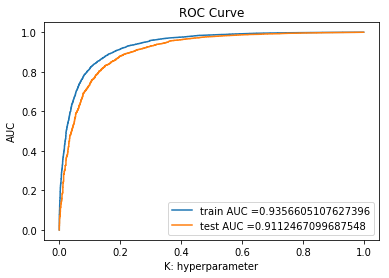

In [61]:
#ROC curve for test and train data
from sklearn.metrics import roc_curve, auc

clf = LogisticRegression(penalty = 'l2',random_state=0, solver='saga', C = 10 ,multi_class="auto",tol=.01)
clf.fit(X_tr_bow, y_tr_bow)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_bow, clf.predict_proba(X_tr_bow)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_bow, clf.predict_proba(X_test_bow)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)



In [62]:
#took help from "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
confusion_matrix(y_test_bow, clf.predict(X_test_bow), labels=[0, 1])

array([[ 1254,   987],
       [  349, 11232]])

#### [5.1.2.1] Performing pertubation test (multicollinearity check) on BOW,<font color='red'> SET 1</font>

1. Get the weights W after fit your model with the data X i.e Train data.
2 .Add a noise to the X (X' = X + e) and get the new data set X' (if X is a sparse matrix, X.data+=e)
3. Fit the model again on data X' and get the weights W'
4. Add a small eps value(to eliminate the divisible by zero error) to W and W’ i.e W=W+10^-6 and W’ = W’+10^-6
6. Now find the % change between W and W' (| (W-W') / (W) |)*100)
7. Calculate the 0th, 10th, 20th, 30th, ...100th percentiles, and observe any sudden rise in the values of percentage_change_vector
Ex: consider your 99th percentile is 1.3 and your 100th percentiles are 34.6, there is sudden rise from 1.3 to  34.6, now calculate the 99.1, 99.2, 99.3,..., 100th percentile values and get the proper value after which there is  sudden rise the values, assume it is 2.5
8. Print the feature names whose % change is more than a threshold x(in our example it's 2.5)

In [63]:
X1_tr_bow = X_tr_bow[:]

In [64]:
clf = LogisticRegression(penalty = 'l1',random_state=0, solver='saga', C = 10 ,multi_class="auto",tol=.01)

clf.fit(X_tr_bow, y_tr_bow)

W = clf.coef_
#print(X1_tr_bow)

In [65]:
X1_tr_bow.data = X1_tr_bow.data +.0001

In [66]:


clf = LogisticRegression(penalty = 'l1',random_state=0, solver='saga', C = 10 ,multi_class="auto",tol=.01)

clf.fit(X1_tr_bow, y_tr_bow)
W1 = clf.coef_


In [67]:
W+=.000001
W1+=.000001


In [68]:
percentage_change_vector = np.abs((W - W1) / (W))*100

In [69]:
lst1 = [0,10,20,30,40,50,60,70,80,90,100]
for i in lst1:
    print(np.percentile(percentage_change_vector, i))

0.0
0.0011378805326586695
0.0021721245938708033
0.0032440229880379284
0.004185303854456876
0.0053770584449281565
0.006717133685216342
0.008661926475526967
0.012387718428653247
0.024990910413702487
113.66329050831226


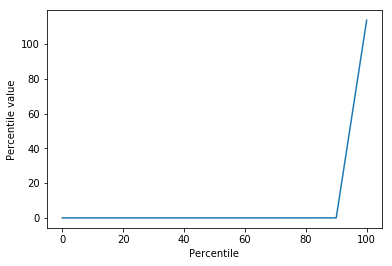

In [70]:
plt.plot(lst1, np.percentile(percentage_change_vector, lst1))
plt.xlabel("Percentile")
plt.ylabel("Percentile value")
plt.show()

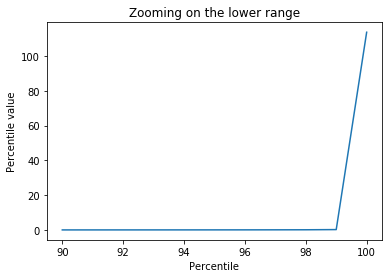

In [71]:
ls = list(np.arange(90, 101))
plt.plot(ls,np.percentile(percentage_change_vector, ls))
plt.xlabel("Percentile")
plt.ylabel("Percentile value")
plt.title("Zooming on the lower range")
plt.show()

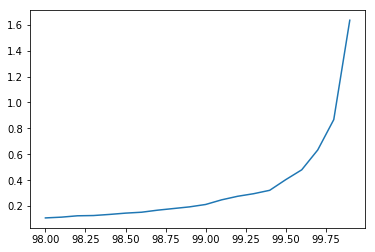

In [74]:
#zooming more to get the exact percentile where the sudden increase is seen
X_99_100 = []
y_99_100 = []
for i in range(0,20):
    X_99_100.append(98+(i*.1))
    y_99_100.append(np.percentile(percentage_change_vector ,98+(i*.1)))
plt.plot(X_99_100, y_99_100)
plt.show()                           

In [75]:
diff = np.percentile(percentage_change_vector ,100) - np.percentile(percentage_change_vector ,99.40)

In [77]:
feature_index = []
for index, change in enumerate(percentage_change_vector[0]):
    if change >= diff:
        feature_index.append(index)
feature_index

[1013]

In [79]:
count_vect.inverse_transform(W[0][1031])

[array(['ability'], dtype='<U27')]

### [5.1.3] Feature Importance on BOW,<font color='red'> SET 1</font>

#### [5.1.3.1] Top 10 important features of positive class from<font color='red'> SET 1</font>

In [80]:
pos_class_prob_sorted  = clf.coef_[0,:].argsort()
print(np.take(count_vect.get_feature_names(), pos_class_prob_sorted[-10:]))

['definitely purchase' 'bbq flavor' 'canine' 'bella' 'bully sticks'
 'certified organic' 'bundle' 'allergic reactions' 'avoiding' 'biting']


#### [5.1.3.2] Top 10 important features of negative class from<font color='red'> SET 1</font>


In [81]:
neg_class_prob_sorted =clf.coef_[0, :].argsort()
print(np.take(count_vect.get_feature_names(), neg_class_prob_sorted[0:10]))

['bad no' 'afghanistan' 'callard' 'advertising' 'delicious also'
 'boston terrier' 'creamy sweet' 'decades' 'crude' 'advertisement']


## [5.2] Logistic Regression on TFIDF,<font color='red'> SET 2</font>

### [5.2.1] Applying Logistic Regression with L1 regularization on TFIDF,<font color='red'> SET 2</font>

In [82]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

clf = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5)
clf.fit(X_tr_tfidv, y_tr_tfidv)

print(clf.best_estimator_)
print(clf.score(X_test_tfidv, y_test_tfidv))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9383737253555184


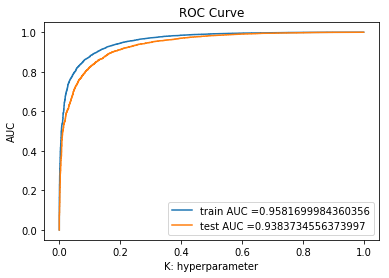

In [83]:
#ROC curve for test and train data
from sklearn.metrics import roc_curve, auc


    # fitting the model on crossvalidation train
clf.fit(X_tr_tfidv, y_tr_tfidv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_tfidv, clf.predict_proba(X_tr_tfidv)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_tfidv, clf.predict_proba(X_test_tfidv)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)



In [84]:
#took help from "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
confusion_matrix(y_test_tfidv, clf.predict(X_test_tfidv), labels=[0, 1])

array([[ 1277,   964],
       [  296, 11285]])

### [5.2.2] Applying Logistic Regression with L2 regularization on TFIDF,<font color='red'> SET 2</font>

In [85]:
from sklearn.model_selection import GridSearchCV
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

clf = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5)
clf.fit(X_tr_tfidv, y_tr_tfidv)

print(clf.best_estimator_)
print(clf.score(X_test_tfidv, y_test_tfidv))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.9443152301999832


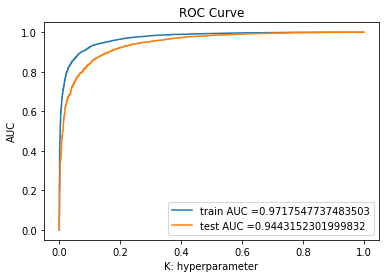

In [86]:
#ROC curve for test and train data
from sklearn.metrics import roc_curve, auc


    # fitting the model on crossvalidation train
clf.fit(X_tr_tfidv, y_tr_tfidv)

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_tfidv, clf.predict_proba(X_tr_tfidv)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_tfidv, clf.predict_proba(X_test_tfidv)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)



In [87]:
#took help from "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
confusion_matrix(y_test_tfidv, clf.predict(X_test_tfidv), labels=[0, 1])

array([[ 1165,  1076],
       [  216, 11365]])

### [5.2.3] Feature Importance on TFIDF,<font color='red'> SET 2</font>

#### [5.2.3.1] Top 10 important features of positive class from<font color='red'> SET 2</font>

In [88]:
pos_class_prob_sorted  = clf.best_estimator_.coef_[0,:].argsort()
print(np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[-10:]))

['wonderful' 'loves' 'excellent' 'nice' 'perfect' 'good' 'love'
 'delicious' 'best' 'great']


#### [5.2.3.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

In [89]:
neg_class_prob_sorted =clf.best_estimator_.coef_[0, :].argsort()
print(np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[0:10]))

['not' 'disappointed' 'worst' 'awful' 'disappointing' 'terrible'
 'horrible' 'money' 'return' 'thought']


## [5.3] Logistic Regression on AVG W2V,<font color='red'> SET 3</font>

### [5.3.1] Applying Logistic Regression with L1 regularization on AVG W2V<font color='red'> SET 3</font>

In [90]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

clf = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5)
clf.fit(sent_vectors_tr, y_tr_w2v)

print(clf.best_estimator_)
print(clf.score(sent_vectors_test, y_test_w2v))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.8848000778021179


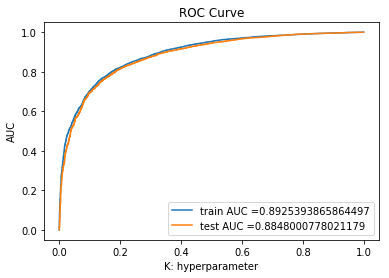

In [91]:
#ROC curve for test and train data
from sklearn.metrics import roc_curve, auc

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_w2v, clf.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_w2v, clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)



In [92]:
#took help from "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
confusion_matrix(y_test_w2v,clf.predict(sent_vectors_test), labels=[0, 1])

array([[  919,  1322],
       [  409, 11172]])

### [5.3.2] Applying Logistic Regression with L2 regularization on AVG W2V,<font color='red'> SET 3</font>

In [93]:
# Please write all the code with proper documentation
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

clf = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5)
clf.fit(sent_vectors_tr, y_tr_w2v)

print(clf.best_estimator_)
print(clf.score(sent_vectors_test, y_test_w2v))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.8848181874472341


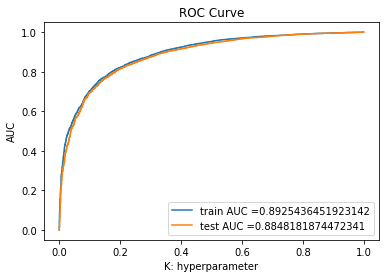

In [94]:

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_w2v, clf.predict_proba(sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_w2v, clf.predict_proba(sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)


In [95]:
#took help from "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
confusion_matrix(y_test_w2v,clf.predict(sent_vectors_test), labels=[0, 1])

array([[  919,  1322],
       [  410, 11171]])

## [5.4] Logistic Regression on TFIDF W2V,<font color='red'> SET 4</font>

### [5.4.1] Applying Logistic Regression with L1 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [96]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

clf = GridSearchCV(LogisticRegression(penalty='l1'), tuned_parameters, scoring = 'roc_auc', cv=5)
clf.fit(tfidf_sent_vectors_tr, y_tr_w2v)

print(clf.best_estimator_)
print(clf.score(tfidf_sent_vectors_test, y_test_w2v))

LogisticRegression(C=100, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l1', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.858547450025182


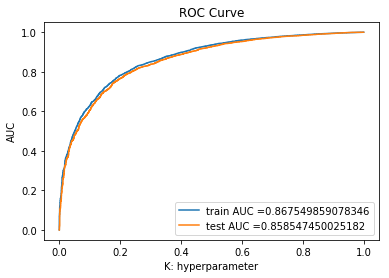

In [97]:

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_w2v, clf.predict_proba(tfidf_sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_w2v, clf.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)


In [98]:
#took help from "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
confusion_matrix(y_test_w2v,clf.predict(tfidf_sent_vectors_test), labels=[0, 1])

array([[  745,  1496],
       [  377, 11204]])

### [5.4.2] Applying Logistic Regression with L2 regularization on TFIDF W2V,<font color='red'> SET 4</font>

In [99]:
# Please write all the code with proper documentation
tuned_parameters = [{'C': [10**-4, 10**-2, 10**0, 10**2, 10**4]}]

clf = GridSearchCV(LogisticRegression(penalty='l2'), tuned_parameters, scoring = 'roc_auc', cv=5)
clf.fit(tfidf_sent_vectors_tr, y_tr_w2v)

print(clf.best_estimator_)
print(clf.score(tfidf_sent_vectors_test, y_test_w2v))

LogisticRegression(C=1, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)
0.8585129261059821


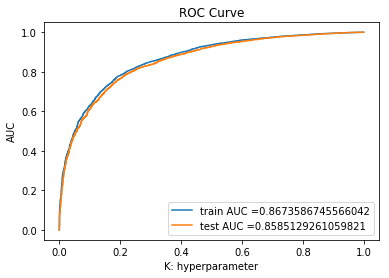

In [100]:

# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_tr_w2v, clf.predict_proba(tfidf_sent_vectors_tr)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test_w2v, clf.predict_proba(tfidf_sent_vectors_test)[:,1])

plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ROC Curve")
plt.show()

print("="*100)


In [101]:
#took help from "https://scikit-learn.org/stable/modules/generated/sklearn.metrics.confusion_matrix.html"
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
confusion_matrix(y_test_w2v,clf.predict(tfidf_sent_vectors_test), labels=[0, 1])

array([[  740,  1501],
       [  370, 11211]])

# [6] Conclusions

In [102]:
# Please compare all your models using Prettytable library
from prettytable import PrettyTable
x = PrettyTable()
x.field_names = ["Model", "Regularization", "AUC_Score"]
x.add_row(["BOW", "l1", 90.84])
x.add_row(["BOW", "l2", 90.84])
x.add_row(["TFIDF", "l1", 93.84])
x.add_row(["TFIDF", "l2", 94.43])
x.add_row(["Average W2V", "l1", 88.48])
x.add_row(["Average W2V", "l2", 88.48])
x.add_row(["TFIDF W2V", "l1", 85.85])
x.add_row(["TFIDF W2V", "l2", 85.85])
print(x)

+-------------+----------------+-----------+
|    Model    | Regularization | AUC_Score |
+-------------+----------------+-----------+
|     BOW     |       l1       |   90.84   |
|     BOW     |       l2       |   90.84   |
|    TFIDF    |       l1       |   93.84   |
|    TFIDF    |       l2       |   94.43   |
| Average W2V |       l1       |   88.48   |
| Average W2V |       l2       |   88.48   |
|  TFIDF W2V  |       l1       |   85.85   |
|  TFIDF W2V  |       l2       |   85.85   |
+-------------+----------------+-----------+
